In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = [1, 2, 3, 4]
g = [1, 1, 1]
h = np.convolve(f, g)
print(h)

[1 3 6 9 7 4]


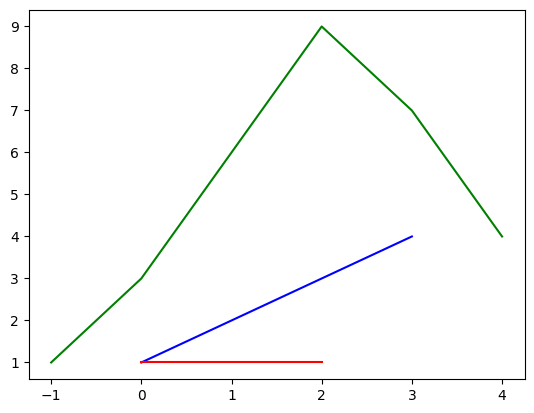

In [3]:
plt.plot(f, 'b', label='f')
plt.plot(g, 'r', label='g')
plt.plot(np.arange(len(h)) - 1, h, 'g', label='f*g')

## Images as 2D (multi-channel) signals

(427, 640, 3)


Text(0.5, 0, 'Blue Channel')

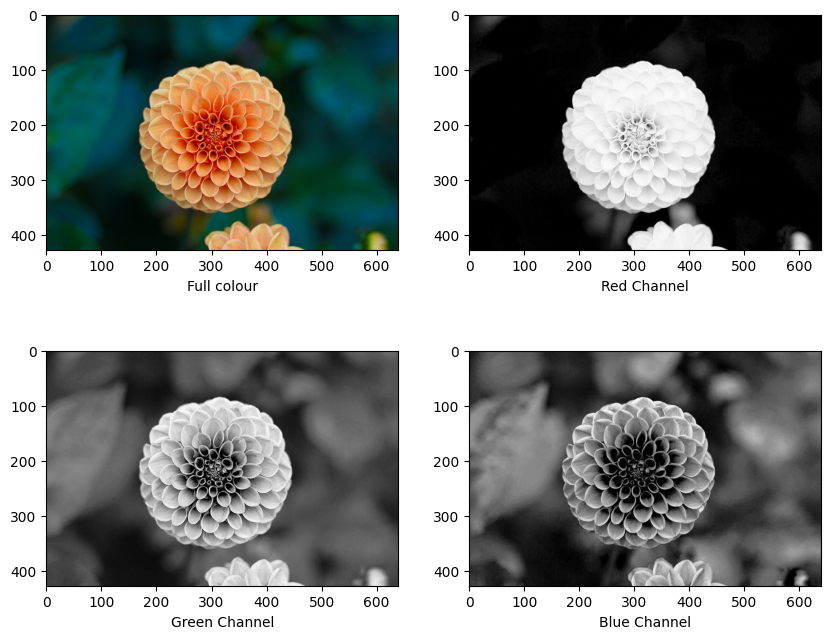

In [4]:
# grab some sample images
from sklearn import datasets
flower = datasets.load_sample_image('flower.jpg')

# Convert to floating point and normalize
flower = flower / 255

fig, ax = plt.subplots(2, 2, figsize=(10,8))
print(flower.shape)
ax[0, 0].imshow(flower)
ax[0, 0].set_xlabel("Full colour")
ax[0, 1].imshow(flower[:,:,0], cmap='Greys_r')
ax[0, 1].set_xlabel("Red Channel")
ax[1, 0].imshow(flower[:,:,1], cmap='Greys_r')
ax[1, 0].set_xlabel("Green Channel")
ax[1, 1].imshow(flower[:,:,2], cmap='Greys_r')
ax[1, 1].set_xlabel("Blue Channel")

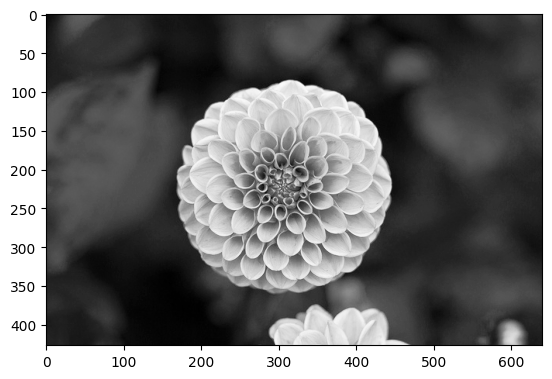

In [5]:
# Take the average of the colour channels to create our greyscale image
flower_g = np.mean(flower, axis=2)
plt.imshow(flower_g, cmap='Greys_r')

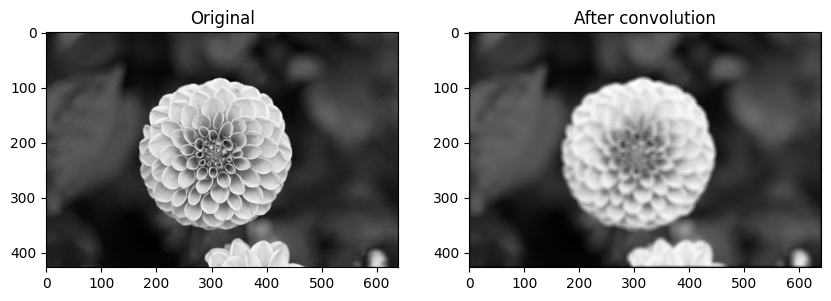

In [17]:
from scipy import signal
# Define a convolution kernel
N = 9
k = np.ones((N, N))

# Normalise the kernel
k = k / N**2

# Convolve it!
flower_conv = signal.convolve2d(flower_g, k, mode='same')

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].set_title("Original")
ax[0].imshow(flower_g, cmap='Greys_r')
ax[1].set_title("After convolution")
ax[1].imshow(flower_conv, cmap='Greys_r')

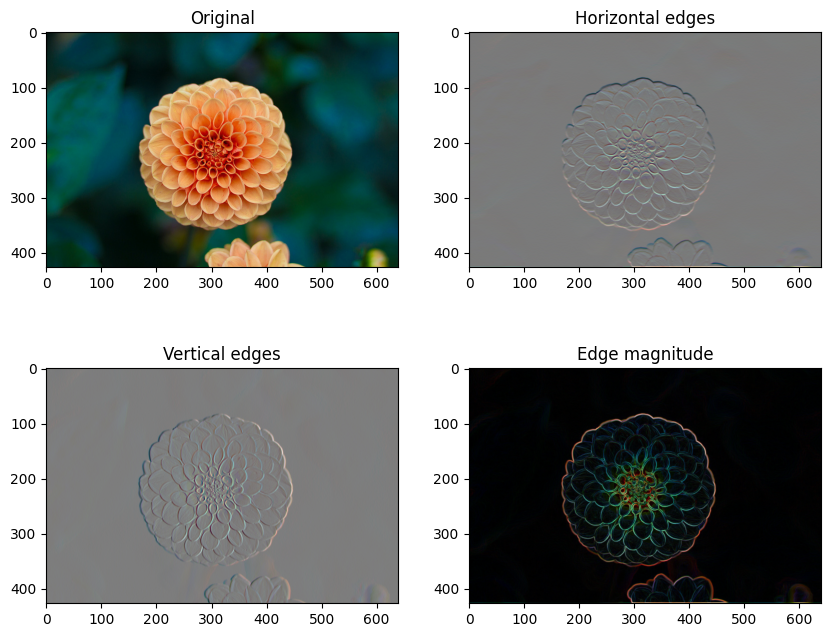

In [22]:
# Sobel kernel - vertical edge detection
k = np.array([[-1, 0, 1],
              [-2, 0, 2],
              [-1, 0, 1]])

# convolution across colour channels
h = np.zeros_like(flower)
v = np.zeros_like(flower)
mag = np.zeros_like(flower)

for i in range(3):
    v[:,:,i] = signal.convolve2d(flower[:,:,i], k, mode='same')
    h[:,:,i] = signal.convolve2d(flower[:,:,i], k.T, mode='same')
    mag[:,:,i] = np.sqrt(h[:,:,i]**2 + v[:,:,i]**2)

# rescale to 0-1
h = (h - h.min()) / (h.max() - h.min())
v = (v - v.min()) / (v.max() - v.min())
mag = (mag - mag.min()) / (mag.max() - mag.min())


fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax[0,0].set_title("Original")
ax[0,0].imshow(flower)
ax[0,1].set_title("Horizontal edges")
ax[0,1].imshow(h)
ax[1,0].set_title("Vertical edges")
ax[1,0].imshow(v)
ax[1,1].set_title("Edge magnitude")
ax[1,1].imshow(mag)

## Convolutional Neural Network for Image Classification
We're going to use the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) to try out a simple classification model. This dataset is intended as a "drop-in replacement" for the original MNIST dataset, and it has the same dimensions and number of classes. MNIST has been deemed "too easy", so Fashion MNIST was created to provide more room for improvement.

Example code based on the [Chapter 14 Notebook](https://github.com/ageron/handson-ml3/blob/main/14_deep_computer_vision_with_cnns.ipynb) from the Scikit-learn book.

In [8]:
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist

# Normalise the data and add a channel dimension
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


4422102/4422102 [==============================] - 0s 0us/step


A typical CNN has a series of convolution/pooling layers, followed by some fully connected layers leading to the final output layer.

`functools` provides a handy method to define a `partial` function with some default arguments, allowing us to re-use the same layer in each conv2d layer.

In [9]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal",
)
model = tf.keras.Sequential(
    [
        DefaultConv2D(filters=64, kernel_size=7, input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128, activation="relu"),
        tf.keras.layers.Dropout(0.5), # adding dropout, hasn't run yet
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=10, activation="softmax"),
    ]
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 256)         0

In [11]:
# compile and train the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Epoch 1/10


1719/1719 [==============================] - 47s 27ms/step - loss: 0.4321 - accuracy: 0.8437 - val_loss: 0.3412 - val_accuracy: 0.8722
Epoch 2/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.2752 - accuracy: 0.8991 - val_loss: 0.2910 - val_accuracy: 0.8910
Epoch 3/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.2287 - accuracy: 0.9162 - val_loss: 0.2432 - val_accuracy: 0.9094
Epoch 4/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.1956 - accuracy: 0.9278 - val_loss: 0.2440 - val_accuracy: 0.9100
Epoch 5/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.1679 - accuracy: 0.9383 - val_loss: 0.2506 - val_accuracy: 0.9098
Epoch 6/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.1463 - accuracy: 0.9456 - val_loss: 0.2412 - val_accuracy: 0.9220
Epoch 7/10
1719/1719 [==============================] - 60s 35ms/step - loss: 0.1278 - accuracy: 0.9519 - val_loss: 0.262

<Axes: >

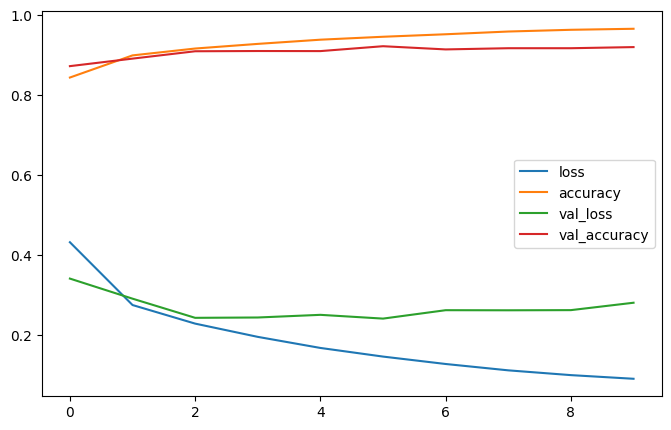

In [12]:
# plot the learning curves
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))

In [13]:
score = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

313/313 [==============================] - 4s 12ms/step


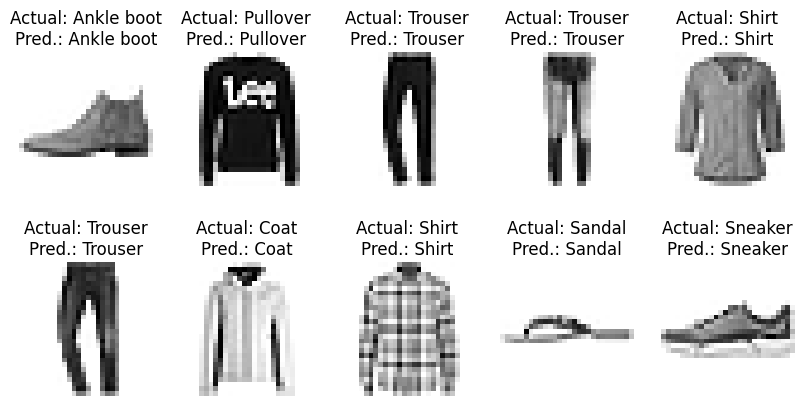

In [14]:
# plot the first 10 test images along with their predicted label
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    r, c = i // 5, i % 5
    ax[r,c].imshow(X_test[i].reshape(28, 28), cmap="binary")
    ax[r,c].axis('off')
    actual_label = class_names[y_test[i]]
    predicted_label = class_names[np.argmax(y_pred[i])]
    ax[r,c].set_title(f"Actual: {actual_label}\nPred.: {predicted_label}")
plt.show()

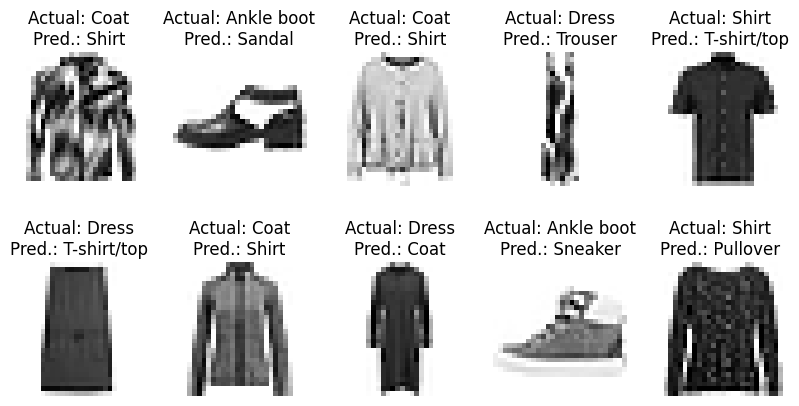

In [15]:
# now plot the first 10 misclassified images
mismatches = np.where(np.argmax(y_pred, axis=1) != y_test)[0]

fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    r, c = i // 5, i % 5
    ax[r,c].imshow(X_test[mismatches[i]].reshape(28, 28), cmap="binary")
    ax[r,c].axis('off')
    actual_label = class_names[y_test[mismatches[i]]]
    predicted_label = class_names[np.argmax(y_pred[mismatches[i]])]
    ax[r,c].set_title(f"Actual: {actual_label}\nPred.: {predicted_label}")
plt.show()

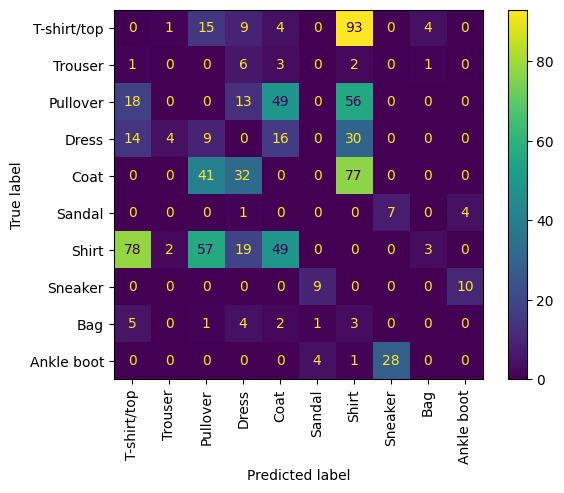

In [16]:
# Look at the confusion matrix to see which classes are being confused
# Only look at the mismatches
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test[mismatches], np.argmax(y_pred, axis=1)[mismatches])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=90)